# Understanding airline accidents using PyMC3

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('bmh')

## Importing Data

In [3]:
crashes = pd.read_excel('aircraft_crashes.xlsx', sheet_name='crashes').drop(['rank'], axis=1).sort_values('year')
deaths = pd.read_excel('aircraft_crashes.xlsx', sheet_name='deaths').drop(['rank'], axis=1).sort_values('year')

In [4]:
pax = pd.read_excel('num_pax.xlsx')

**Selecting data for accidents after 1975 and up to 2019**

In [5]:
crashes = crashes.loc[(crashes.year>=1975) & (crashes.year<=2019)].reset_index(drop=True)
deaths = deaths.loc[(deaths.year>=1975) & (deaths.year<=2019)].reset_index(drop=True)

## Exploratory Data Analysis

### 1. Time series of crashes and fatalities

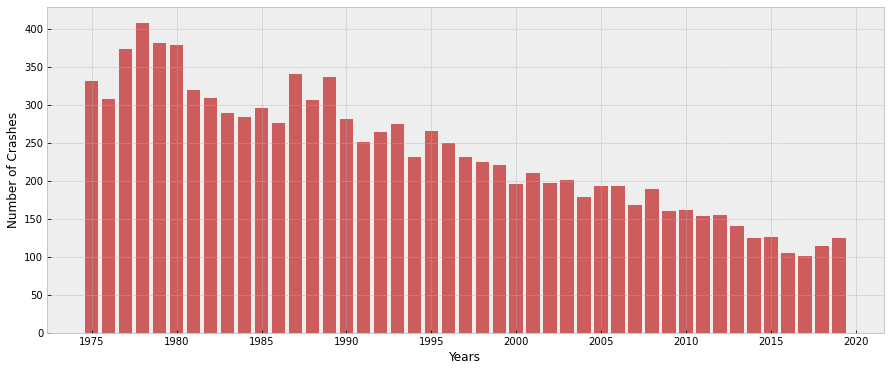

In [6]:
fig,ax = plt.subplots(figsize=[15,6])
ax.bar(crashes.year, crashes.num_crashes, color='indianred')
ax.set_xticks(np.arange(1975, 2021, 5))
ax.set_xlabel('Years', fontsize=12)
ax.set_ylabel('Number of Crashes', fontsize=12)
plt.show()

In [7]:
df = pd.concat([crashes, deaths[['fatalities']]], axis=1)

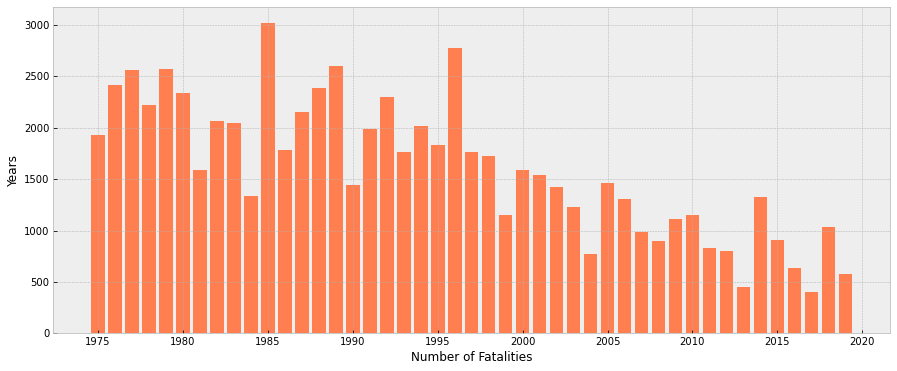

In [8]:
fig,ax = plt.subplots(figsize=[15,6])
ax.bar(deaths.year, deaths.fatalities, color='coral')
ax.set_xticks(np.arange(1975, 2021, 5))
ax.set_ylabel('Years', fontsize=12)
ax.set_xlabel('Number of Fatalities', fontsize=12)
plt.show()

No handles with labels found to put in legend.


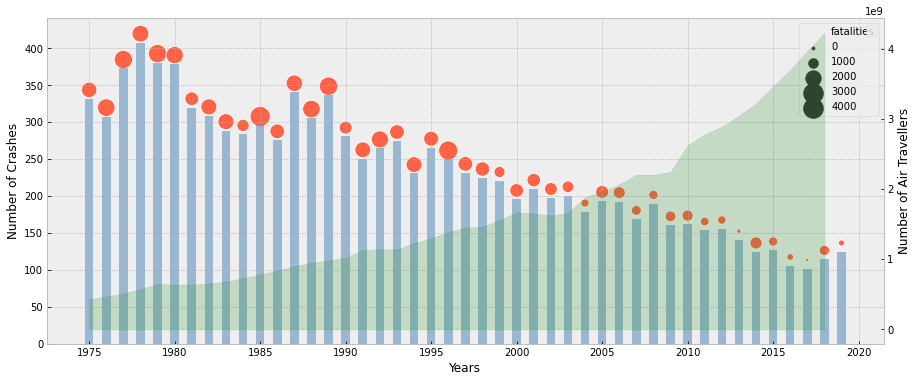

In [9]:
fig, ax1 = plt.subplots(figsize=[15,6])

ax1.bar(crashes.year, crashes.num_crashes, 
        width=0.5, alpha=0.5, color='steelblue')

sns.scatterplot(crashes.year, crashes.num_crashes+12, 
                size=deaths.fatalities, sizes=(10,400),
                color='tomato', ax=ax1)
ax2 = ax1.twinx()
ax2.fill_between(pax.year, pax.num_pax, 
                 color='forestgreen', alpha=0.2)

ax1.set_xticks(np.arange(1975, 2021, 5))
ax1.set_xlabel('Years')
ax1.set_ylabel('Number of Crashes')
ax2.set_ylabel('Number of Air Travellers')

ax2.grid(False)

plt.legend(prop={'size':14})

### 2. Fatalities per million air travellers

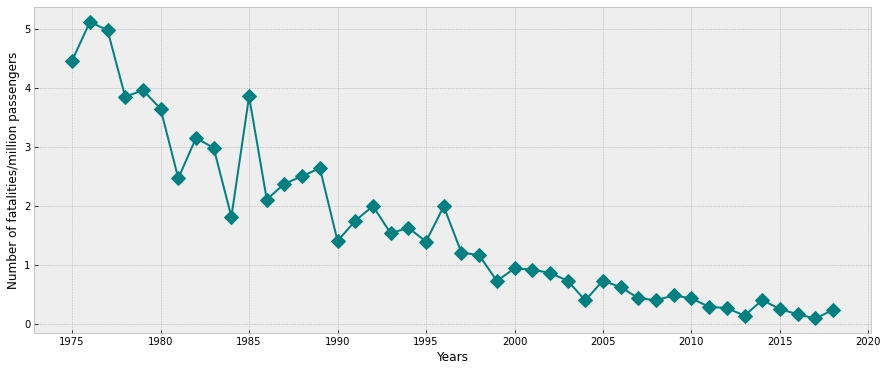

In [10]:
fig = plt.subplots(figsize=[15,6])
plt.plot(df.year, (df.fatalities/pax.num_pax)*1E6, 
         marker='D', ms=10, color='teal')
plt.xticks(np.arange(1975, 2021, 5))
plt.xlabel('Years')
plt.ylabel('Number of fatalities/million passengers')
plt.show()

### 3. Fatalities per accident

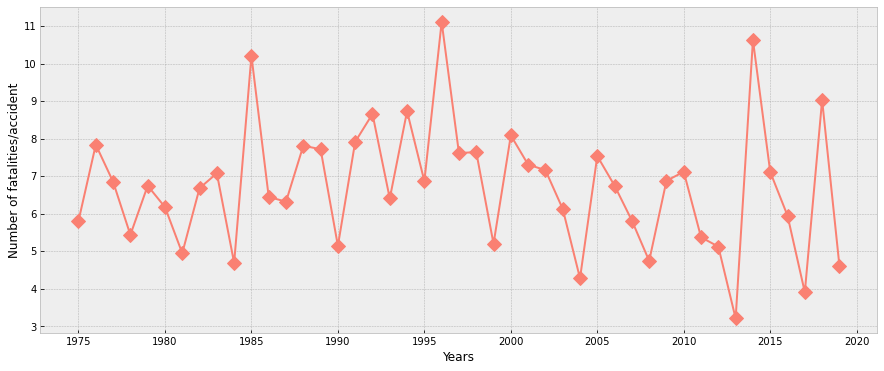

In [11]:
fig = plt.subplots(figsize=[15,6])
plt.plot(df.year, (df.fatalities/df.num_crashes), 
         marker='D', ms=10, color='salmon')
plt.xticks(np.arange(1975, 2021, 5))
plt.xlabel('Years')
plt.ylabel('Number of fatalities/accident')
plt.show()

### 4. Yearly Rate of change of accidents

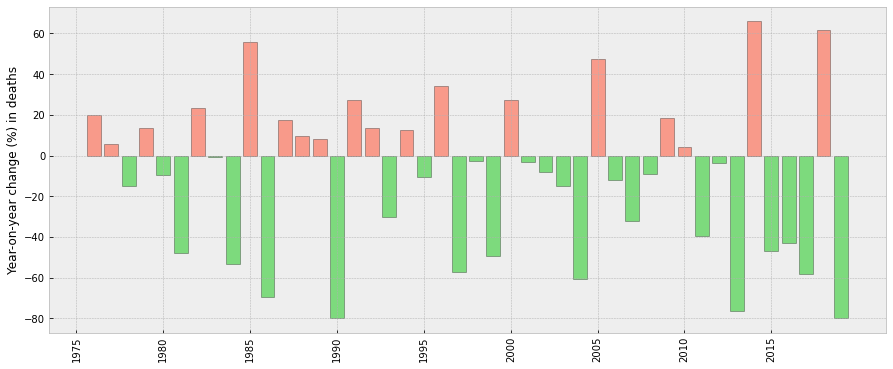

In [12]:
year_on_year_death = df.fatalities.diff()*100/df.fatalities

fig,ax = plt.subplots(figsize=[15,6])
for i in range(0,df.shape[0]):
    if (year_on_year_death[i]>=0):
        plt.bar(df.year[i], year_on_year_death[i], color='tomato', edgecolor='k', alpha=0.6)
    else:
        plt.bar(df.year[i], year_on_year_death[i], color='limegreen', edgecolor='k', alpha=0.6)
plt.xticks( np.arange(1975, 2020, 5), np.arange(1975, 2020, 5), rotation=90)
plt.ylabel('Year-on-year change (%) in deaths', fontsize=12)
plt.show()

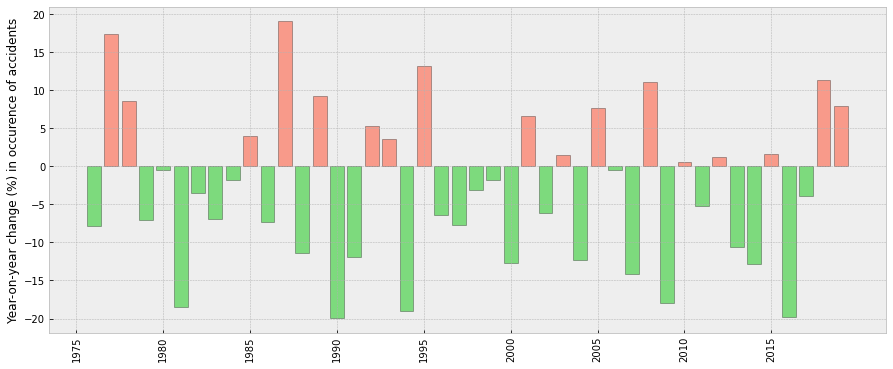

In [13]:
year_on_year_accident = df.num_crashes.diff()*100/df.num_crashes

fig,ax = plt.subplots(figsize=[15,6])
for i in range(0,df.shape[0]):
    if (year_on_year_accident[i]>=0):
        plt.bar(df.year[i], year_on_year_accident[i], color='tomato', edgecolor='k', alpha=0.6)
    else:
        plt.bar(df.year[i], year_on_year_accident[i], color='limegreen', edgecolor='k', alpha=0.6)
plt.xticks( np.arange(1975, 2020, 5), np.arange(1975, 2020, 5), rotation=90)
plt.ylabel('Year-on-year change (%) in occurence of accidents', fontsize=12)
plt.show()

## Probabilistic Programming with PyMC3

In [14]:
import pymc3 as pm
import arviz as az
print("Running on PyMC3 v{}".format(pm.__version__))

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Running on PyMC3 v3.9.2


**This model can be run for data from 1975 to 2020. All you need to do is replace 2000 with 1975**

In [15]:
years = np.arange(2000, 2020)
with pm.Model() as accident_model:
    
    alpha = 1/df.loc[df.year>=2000].num_crashes.mean()
    # Setting the prior belief for the inflection point
    change_point = pm.DiscreteUniform(
                    'change_point', lower=2000, upper=2020)
    
    # Setting prior belif for the rate of change, ie, lambda, before and after inflection
    rate_before = pm.Exponential('before_change', alpha)
    rate_after = pm.Exponential('after_change', alpha)
    
    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(change_point >= years, rate_before, rate_after)

    accidents = pm.Poisson("accidents", rate, observed=df.loc[df.year>=2000].num_crashes)

In [16]:
with accident_model:
    trace = pm.sample(10000, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [change_point]
>NUTS: [after_change, before_change]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
The number of effective samples is smaller than 10% for some parameters.


/Users/anirudhchandra/anaconda3/envs/prob_prog/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e9d3630>,
      dtype=object)

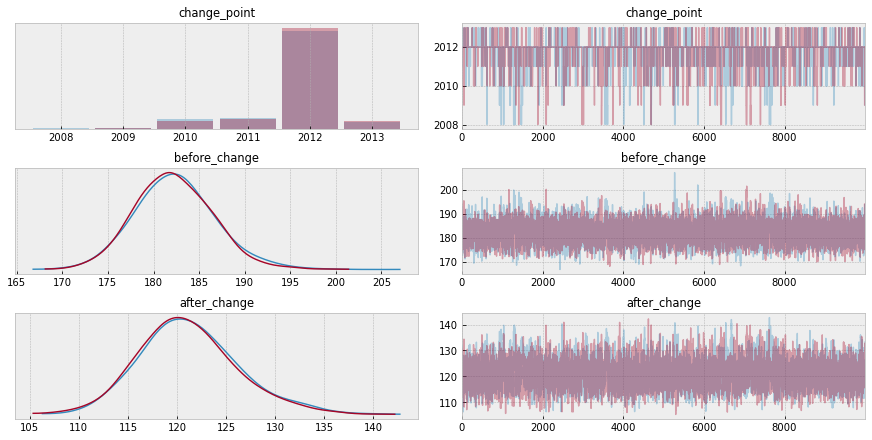

In [17]:
az.plot_trace(trace)

/Users/anirudhchandra/anaconda3/envs/prob_prog/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11fafb8d0>,
      dtype=object)

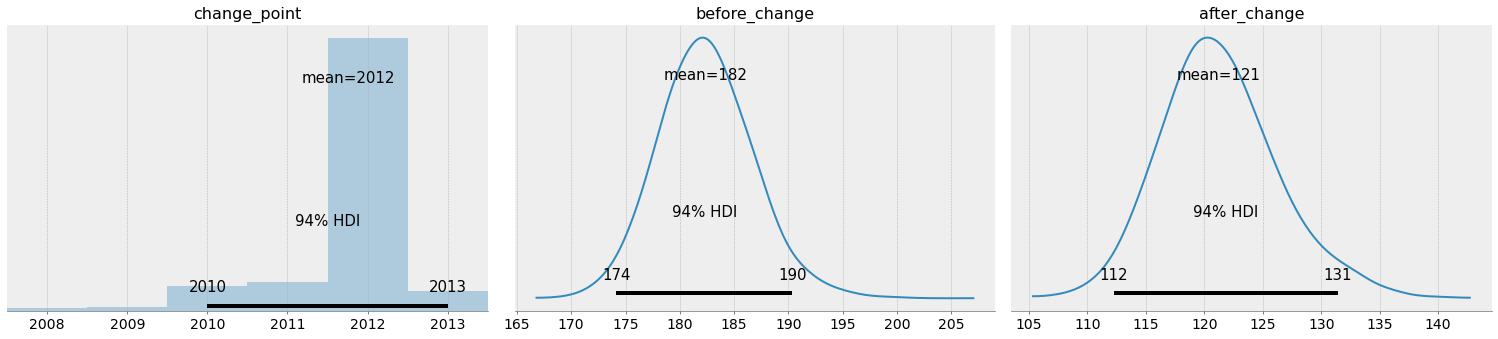

In [18]:
az.plot_posterior(trace)